In [6]:
from collections import Counter
import numpy as np
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
from utils.hmatrStatistics import Hmatr

%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2
rpy2.robjects.numpy2ri.activate()

rssa = importr('Rssa')

D:\Program Files\anaconda\envs\researchWork\lib\site-packages\rpy2\robjects\pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Аналитическое исследование индекса неоднородности

Для простоты, пусть наш ряд задан как $x_n = sin(2\pi \omega n)$, причем $\begin{equation*} \omega = \begin{cases} \omega_1\ n \in [0, Q-1] \\ \omega_2\ n\in [Q, N-1] \end{cases} \end{equation*}$

Проведем аналитический анализ индекса неоднородности. Вспомним как он задается:
$$g(F^{(1)}; F^{(2)}) = \frac{\sum\limits_{l=1}^{K_2}\mathrm{dist}^2(X_l^{(2)}, \mathfrak{L}_r^{(1)})}{\sum\limits_{l=1}^{K_2}\|X_l^{(2)}\|^2} = \frac{\sum\limits_{l=1}^{K_2}\;(\|X_l^{(2)}\|^2 - \sum\limits_{i=1}^{r}\langle X_l^{(2)}, U_i^{(1)}\rangle^2)}{\sum\limits_{l=1}^{K_2}\|X_l^{(2)}\|^2} = 1 - \frac{\sum\limits_{l=1}^{K_2}\;\sum\limits_{i=1}^{r}\langle X_l^{(2)}, U_i^{(1)}\rangle^2}{\sum\limits_{l=1}^{K_2}\|X_l^{(2)}\|^2}$$


## Знаменатель

Начнем со знаменателя $\sum\limits_{l=1}^{K_2}\|X_l^{(2)}\|^2$, а точнее, с квадрата нормы $\|X_l^{(2)}\|^2$. Оценим его:

$$ \|X_l^{(2)}\|^2 = \sum\limits_{i=1}^{L}(X_{l_i}^{(2)}) = \int\limits_{0}^{L}X_{l_i}^{(2)} = \int\limits_{0}^{L}\sin^2{(2\pi\omega_2 y)}dy = \frac{L}{2} - \frac{\sin(4\pi L\omega_2)}{8\pi\omega_2} \approx \frac{L}{2} $$

Отсюда $\sum\limits_{l=1}^{K_2}\|X_l^{(2)}\|^2 \approx K_2\cdot\frac{L}{2}$.

Проверим равенство программно.

In [40]:
N = 700
w1 = 1/10
w2 = 1/5
C = 1
phi1 = 0
phi2 = 0
Q = 301
B = 100
T_ = 100
L = 20
r = 2
method = "svd"

In [41]:
def generate_series(omega, C=1, N=700, Q=301):
    w1, w2 = omega
    series = lambda n: C*np.sin(2*np.pi*w1*n + phi1) if n < Q-1 else C*np.sin(2*np.pi*w2*n + phi1)
    return [series(i) for i in range(N)]

In [42]:
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)

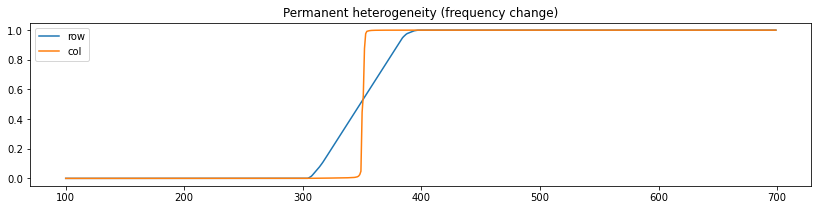

In [44]:
hm.plotHeterFunc('Permanent heterogeneity (frequency change)', 14, 3)

В формуле расстояния считаются между базовыми и тестовыми подрядами. В знаменателе $X_l^{(2)}$ -  столбцы траекторной матрицы тестового подряда (в формуле (2.1) ряда $F^{(2)}$). Длина таких рядов равна $T$, а длина окна равна $L$. Отсюда $K_2 = T - L$

In [5]:
K2 = T_ - L
K2

50

In [6]:
K2 * L/2

1250.0

Проверим полученную аналитически оценку эмпирически.

In [7]:
sum(hm.STATISTICS['norm'])/len(hm.STATISTICS['norm'])

1250.0

Получили то же самое число, правда в среднем. Посмотрим на значения, которые встречались:

In [8]:
Counter(hm.STATISTICS['norm'])

Counter({1250.0: 560, 1250.5590169943753: 20, 1249.4409830056247: 20})

Как мы видим, значения не сильно отклоняются от среднего. Отсюда можно заключить, что хвост $\frac{\sin(4\pi L\omega_2)}{8\pi\omega_2}$, отнимаемый от $\frac{L}{2}$ ассимптотически не влияет на оценку $\sum\limits_{l=1}^{K_2}\|X_l^{(2)}\|^2$ и при достаточно больших $L$ мы имеем равенство: $\sum\limits_{l=1}^{K_2}\|X_l^{(2)}\|^2 = K_2\cdot\frac{L}{2}$.

Для подтверждения нашего предположения, проведем еще несколько экспериментов.

---

1

In [9]:
L = 990
N = 1700
Q = 801
B = 1000
T_ = 1000
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
print(sum(hm.STATISTICS['norm'])/len(hm.STATISTICS['norm']))
print(Counter(hm.STATISTICS['norm']))

R[write to console]: Warning:
R[write to console]:  package 'Rssa' is in use and will not be installed



4950.0
Counter({4950.0: 660, 4950.000000000002: 14, 4950.000000000004: 10, 4949.999999999993: 10, 4950.000000000001: 6})


In [10]:
K2 = T_ - L
K2 * L/2

4950.0

---

2

In [51]:
L = 400
N = 1700
Q = 301
B = 1000
T_ = 1000
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
print(sum(hm.STATISTICS['norm'])/len(hm.STATISTICS['norm']))
print(Counter(hm.STATISTICS['norm']))

119999.90416851516
Counter({120000.0: 580, 119999.44098300562: 120})


In [52]:
K2 = T_ - L
K2 * L/2

120000.0

Получили примерно те же самые значения и чем больше L, тем меньше влияет $\frac{\sin(4\pi L\omega_2)}{8\pi\omega_2}$.

---

## Числитель

Для простоты мы взяли ряд, состоящий из синусов. Его ранг равен $ 2 $ и скалярное произведение будет состоять из одинаковых слагаемых.



$$ \sum\limits_{l=1}^{K_2}\;\sum\limits_{i=1}^{r}\langle X_l^{(2)}, U_i^{(1)}\rangle^2 = \sum\limits_{l=1}^{K_2}\;\sum\limits_{i=1}^{r}\;\left (\sum\limits_{j=1}^{L}X_{l_j}^{(2)}\cdot U_{i_j}^{(1)}\right )^2 \approx \sum\limits_{l=1}^{K_2}\;\sum\limits_{i=1}^{r} \left (\int\limits_{0}^{L}(X_{l}^{(2)} \cdot U_{i}^{(1)})dy\right )^2 = $$
$$ = \sum\limits_{l=1}^{K_2}\;\left[\left(\int\limits_{0}^{L}(X_{l}^{(2)} \cdot U_{1}^{(1)})dy\right )^2 + \left(\int\limits_{0}^{L}(X_{l}^{(2)} \cdot U_{2}^{(1)})dy\right )^2\right ] \approx $$
$$ \approx K_2 \cdot\left[\left(\int\limits_{0}^{L}(X_{l}^{(2)} \cdot U_{1}^{(1)})dy\right )^2 + \left(\int\limits_{0}^{L}(X_{l}^{(2)} \cdot U_{2}^{(1)})dy\right )^2\right ] = $$

$$ = K_2 \cdot\left[\left(\int\limits_{0}^{L}(\sin(2\pi\omega_2 y) \cdot \frac{\sin(2\pi\omega_1 y)}{\sqrt{L/2}}dy\right )^2 + \left(\int\limits_{0}^{L}(\sin(2\pi\omega_2 y) \cdot \frac{\cos(2\pi\omega_1 y)}{\sqrt{L/2}})dy\right )^2\right ] = $$
$$ = K_2 \cdot \frac{2}{L} \cdot\left[\left(\int\limits_{0}^{L}(\sin(2\pi\omega_2 y) \cdot \sin(2\pi\omega_1 y)dy\right )^2 + \left(\int\limits_{0}^{L}(\sin(2\pi\omega_2 y) \cdot \cos(2\pi\omega_1 y))dy\right )^2\right ] $$

## Индекс неоднородности

Собирая все вместе, получаем:

$$ 1 - \frac{\sum\limits_{l=1}^{K_2}\;\sum\limits_{i=1}^{r}\langle X_l^{(2)}, U_i^{(1)}\rangle^2}{\sum\limits_{l=1}^{K_2}\|X_l^{(2)}\|^2} \approx  $$
$$ \approx 1 - \frac{K_2 \cdot \frac{2}{L} \cdot\left[\left(\int\limits_{0}^{L}(\sin(2\pi\omega_2 y) \cdot \sin(2\pi\omega_1 y)dy\right )^2 + \left(\int\limits_{0}^{L}(\sin(2\pi\omega_2 y) \cdot \cos(2\pi\omega_1 y))dy\right )^2\right ]}{K_2\cdot\frac{L}{2}} = $$
$$ = 1 - \frac{\left(\int\limits_{0}^{L}(\sin(2\pi\omega_2 y) \cdot \sin(2\pi\omega_1 y)dy\right )^2 + \left(\int\limits_{0}^{L}(\sin(2\pi\omega_2 y) \cdot \cos(2\pi\omega_1 y))dy\right )^2}{\frac{L^2}{4}} = $$
$$ = 1 - \frac{\left[ \left(  \frac{\sin(2\pi Lb)}{4\pi b} - \frac{\sin(2\pi La)}{4\pi a}   \right)^2 + \left(  \frac{\cos(2\pi Lb)}{4\pi b} - \frac{\cos(2\pi La)}{4\pi a}  \right)^2 \right]}{\frac{L^2}{4}} $$

где $a = \omega_1 + \omega_2$, $b = \omega_1 - \omega_2$.


Сравним полученную формулу с оригинальной.

In [55]:
N = 700
Q = 301
B = 100
T_ = 100

Возьмем $\omega_1 = \frac{1}{10}$, $\omega_2 = \frac{1}{20}$ и сравним индексы неоднородности до и после разладки.

In [12]:
w1 = 1/10
w2 = 1/20
L = 60
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.compute_single_row(0)[1], hm.compute_single_row(0)[-1]

(0.0, 1.0)

In [13]:
hm.compute_single_val_analytical(1/10, 1/10), hm.compute_single_val_analytical(1/10, 1/20)

(0.0, 0.9987491211896008)

Увеличим $L$ до $80$

In [61]:
w1 = 1/10
w2 = 1/20
L = 80
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.compute_single_row(0)[-1]

1.0

In [62]:
hm.compute_single_val_analytical(1/10, 1/20)

0.9992963806691504

Уменьшим $L$ до $40$

In [63]:
w1 = 1/10
w2 = 1/20
L = 40
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.compute_single_row(0)[-1]

1.0

In [64]:
hm.compute_single_val_analytical(1/10, 1/20)

0.9971855226766018

Получили похожие числа. Наблюдается подтверждение предположение о зависимости значений аналитической формулы от величины $L$.

---

Уменьшим разность частот, сохранив $L=50$: $\omega_1 = \frac{1}{10}$, $\omega_2 = \frac{1}{11}$

In [14]:
w1 = 1/10
w2 = 1/11
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.getRow()[-1], hm.compute_single_val_analytical(w1, w2)

(0.6659330299999999, 0.9214902036531843)

Увеличим $L$ до $80$

In [15]:
w1 = 1/10
w2 = 1/11
L = 80
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.getRow()[-1], hm.compute_single_val_analytical(w1, w2)

(0.89075337, 0.947625104932811)

Получили более близкие друг к другу значения. Увеличим $L=90$

In [16]:
w1 = 1/10
w2 = 1/11
L = 90
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.getRow()[-1], hm.compute_single_val_analytical(w1, w2)

(0.95585467, 0.9597151768519586)

С ростом $L$ значения индекса неоднородности сходятся друг к другу.

---

In [15]:
w1 = 1/10
w2 = 1/10+1/100
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.getRow()[-1], hm.compute_single_val_analytical(w1, w2)

(0.5935171, 0.5551977062776277)

In [23]:
from matplotlib import pyplot as plt
L= 50
def generate_gs_comparsion_omegas():
    w1 = 1/10
    w2 = 1/np.arange(10, 12, 0.02)

    gs_a = []
    gs_c = []

    for i in range(len(w2)):
        f = generate_series((w1, w2[i]), N=N, Q=Q)
        hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
        gs_c.append(hm.compute_single_row(0)[-1])
        gs_a.append(hm.compute_single_val_analytical(w1, w2[i], verbose=False))
    return w1, w2, gs_a, gs_c

In [24]:
w1_, w2_, gs_a, gs_c = generate_gs_comparsion_omegas()

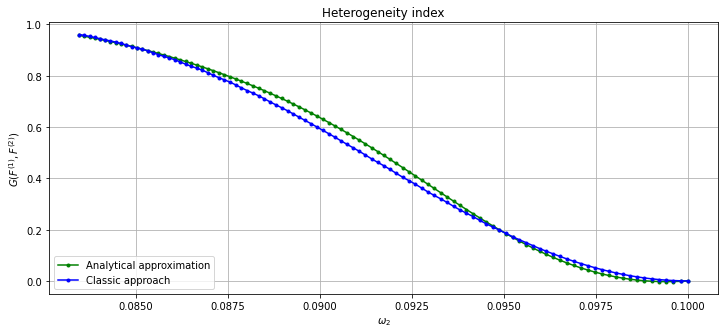

In [25]:
plt.figure(figsize=(12, 5))
plt.title("Heterogeneity index")
plt.xlabel(r"$\omega_2$")
plt.ylabel(r"$G(F^{(1)}, F^{(2)})$")
plt.grid()
plt.plot(w2_, gs_a, marker=".", color="g", label="Analytical approximation")
plt.plot(w2_, gs_c, marker=".", color="b", label="Classic approach")
plt.legend(loc = "lower left")
# plt.savefig("dynamics_w2.png")

In [30]:
from matplotlib import pyplot as plt
L = 90
def generate_gs_comparsion_omegas():
    w1 = 1/10
    w2 = 1/np.arange(10, 12, 0.02)

    gs_a = []
    gs_c = []

    for i in range(len(w2)):
        f = generate_series((w1, w2[i]), N=N, Q=Q)
        hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
        gs_c.append(hm.compute_single_row(0)[-1])
        gs_a.append(hm.compute_single_val_analytical(w1, w2[i], verbose=False))
    return w1, w2, gs_a, gs_c

In [31]:
w1_, w2_, gs_a, gs_c = generate_gs_comparsion_omegas()

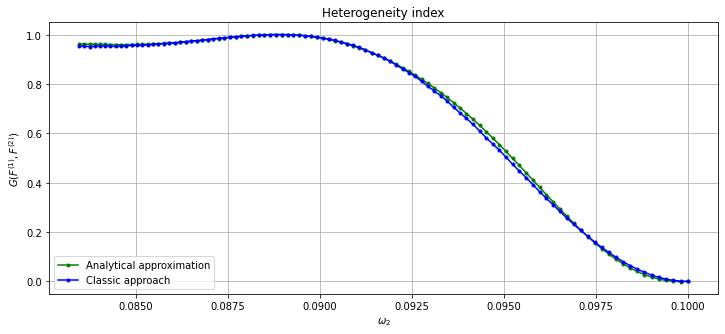

In [32]:
plt.figure(figsize=(12, 5))
plt.title("Heterogeneity index")
plt.xlabel(r"$\omega_2$")
plt.ylabel(r"$G(F^{(1)}, F^{(2)})$")
plt.grid()
plt.plot(w2_, gs_a, marker=".", color="g", label="Analytical approximation")
plt.plot(w2_, gs_c, marker=".", color="b", label="Classic approach")
plt.legend(loc = "lower left")
# plt.savefig("dynamics_w2.png")

---

In [124]:
w1 = 1/10
w2 = 1/11
L = 40
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.getRow()[-1], hm.compute_single_val_analytical(w1, w2)

(0.36404161999999995, 0.4040927156942612)

In [99]:
w1 = 1/10
w2 = 1/11
L = 40
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.getRow()[-1], hm.compute_single_val_analytical(w1, w2)

R[write to console]: Warning:
R[write to console]:  package 'Rssa' is in use and will not be installed



(0.36404161999999995, 0.37741304893325733)

---

### Динамика по $\omega_2$

In [26]:
from matplotlib import pyplot as plt

def generate_gs_comparsion_omegas():
    w1 = 1/10
    w2 = 1/np.arange(10, 20, 0.2)

    gs_a = []
    gs_c = []

    for i in range(len(w2)):
        f = generate_series((w1, w2[i]), N=N, Q=Q)
        hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
        gs_c.append(hm.compute_single_row(0)[-1])
        gs_a.append(hm.compute_single_val_analytical(w1, w2[i], verbose=False))
    return w1, w2, gs_a, gs_c

In [27]:
w1_, w2_, gs_a, gs_c = generate_gs_comparsion_omegas()

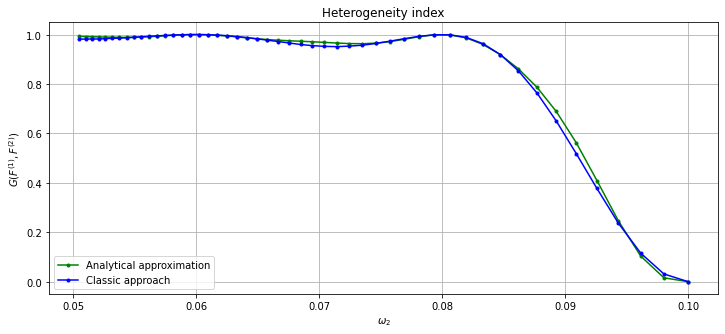

In [28]:
plt.figure(figsize=(12, 5))
plt.title("Heterogeneity index")
plt.xlabel(r"$\omega_2$")
plt.ylabel(r"$G(F^{(1)}, F^{(2)})$")
plt.grid()
plt.plot(w2_, gs_a, marker=".", color="g", label="Analytical approximation")
plt.plot(w2_, gs_c, marker=".", color="b", label="Classic approach")
plt.legend(loc = "lower left")
# plt.savefig("dynamics_w2.png")

### Динамика по $L$

In [117]:
def generate_gs_comparsion_Ls():
    w1 = 1/10
    w2 = 1/11
    B = 200
    T_ = 200
    L = np.arange(10, 110, 1, dtype=int)
    f = generate_series((w1, w2), N=N, Q=Q)
    hm = Hmatr(f, B, T_, 20, neig=r, svdMethod=method)
    
    gs_a = []
    gs_c = []

    for i in range(len(L)):
#         hm = Hmatr(f, B, T_, L[i], neig=r, svdMethod=method)
        gs_c.append(hm.compute_single_row(0, L[i])[-1])
        gs_a.append(hm.compute_single_val_analytical(w1, w2, verbose=False))
    return L, gs_a, gs_c

In [118]:
L_, gs_a, gs_c = generate_gs_comparsion_Ls()

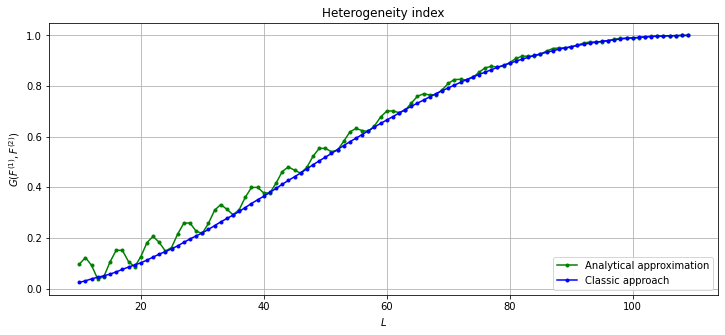

In [119]:
plt.figure(figsize=(12, 5))
plt.title("Heterogeneity index")
plt.xlabel(r"$L$")
plt.ylabel(r"$G(F^{(1)}, F^{(2)})$")
plt.grid()
plt.plot(L_, gs_a, marker=".", color="g", label="Analytical approximation")
plt.plot(L_, gs_c, marker=".", color="b", label="Classic approach")
plt.legend(loc = "lower right")
plt.savefig("/report/tex/images/dynamics_L.png")

R[write to console]: Warning:
R[write to console]:  package 'Rssa' is in use and will not be installed



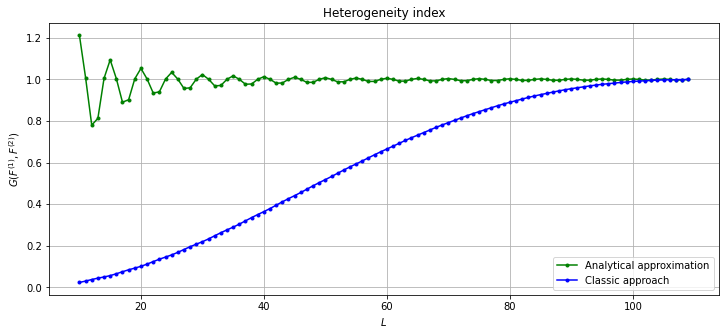

In [122]:
L_, gs_a, gs_c = generate_gs_comparsion_Ls()
plt.figure(figsize=(12, 5))
plt.title("Heterogeneity index")
plt.xlabel(r"$L$")
plt.ylabel(r"$G(F^{(1)}, F^{(2)})$")
plt.grid()
plt.plot(L_, gs_a, marker=".", color="g", label="Analytical approximation")
plt.plot(L_, gs_c, marker=".", color="b", label="Classic approach")
plt.legend(loc = "lower right")

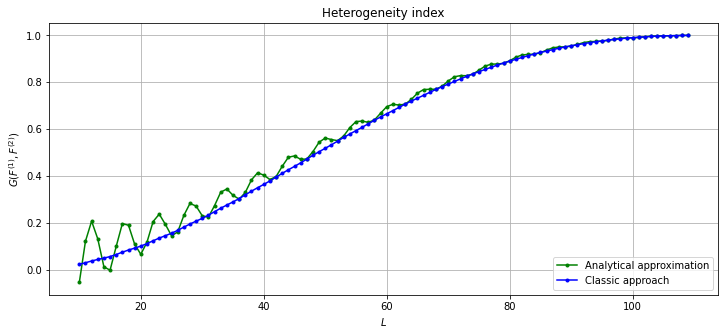

In [125]:
L_, gs_a, gs_c = generate_gs_comparsion_Ls()
plt.figure(figsize=(12, 5))
plt.title("Heterogeneity index")
plt.xlabel(r"$L$")
plt.ylabel(r"$G(F^{(1)}, F^{(2)})$")
plt.grid()
plt.plot(L_, gs_a, marker=".", color="g", label="Analytical approximation")
plt.plot(L_, gs_c, marker=".", color="b", label="Classic approach")
plt.legend(loc = "lower right")

### Краевые случаи

#### $a = 2\omega_1,\; b = 0$

In [77]:
w1 = 1/10
w2 = w1
L = 90
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.getRow()[-1], hm.compute_single_val_analytical(w1, w2)

(0.0, 3.3306690738754696e-16)

#### $a = \omega_1,\; b = \omega_1$

In [83]:
w1 = 1/10
w2 = 1e-10
L = 90
f = generate_series((w1, w2), N=N, Q=Q)
hm = Hmatr(f, B, T_, L, neig=r, svdMethod=method)
hm.getRow()[-1], hm.compute_single_val_analytical(w1, w2)

(1.0, 1.0)